In [37]:
import pandas as pd
from pandas import Series, DataFrame
%pylab inline
import numpy as np
import statsmodels.api as sm
from patsy import dmatrices
from copy import deepcopy
from sklearn.cross_validation import train_test_split
from sklearn import neighbors
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import naive_bayes
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from StringIO import StringIO
import pydot_ng

Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['axes', 'types']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
intakes = pd.read_csv('https://query.data.world/s/4dhuacn0l3k8nw0f5strehu96')
intakes.columns = ['Animal ID', 'Name', 'DateTime', 'MonthYear', 'Found_Location',
       'Intake_Type', 'IntakeCondition', 'Animal_Type', 'Sex',
       'Age', 'Breed', 'Color']

outcomes = pd.read_csv('https://query.data.world/s/1hjzqlp0xrqs5k8rfa6le49yn')
outcomes.columns = ['Animal ID', 'Name', 'DateTime', 'MonthYear', 'DOB',
       'Outcome_Type', 'Outcome_Subtype', 'Animal_Type',
       'Sex_upon_Outcome', 'Age_upon_Outcome', 'Breed', 'Color']

In [4]:
print "How many intakes and outcomes do we have?"
print len(intakes), "intakes"
print len(outcomes), "outcomes"
print "What are the columns?"
print "INTAKE: ",intakes.columns
print "OUTCOMES: ",outcomes.columns

How many intakes and outcomes do we have?
63328 intakes
63643 outcomes
What are the columns?
INTAKE:  Index([u'Animal ID', u'Name', u'DateTime', u'MonthYear', u'Found_Location',
       u'Intake_Type', u'IntakeCondition', u'Animal_Type', u'Sex', u'Age',
       u'Breed', u'Color'],
      dtype='object')
OUTCOMES:  Index([u'Animal ID', u'Name', u'DateTime', u'MonthYear', u'DOB',
       u'Outcome_Type', u'Outcome_Subtype', u'Animal_Type',
       u'Sex_upon_Outcome', u'Age_upon_Outcome', u'Breed', u'Color'],
      dtype='object')


In [5]:
# Create a new dataframe from the inner join between intakes and outcomes
records = intakes.merge(outcomes, how='inner', left_on = 'Animal ID', right_on = 'Animal ID', suffixes=('_intake', '_outcome'))
print "Resulting dataframe has", len(records), "records"

Resulting dataframe has 76977 records


## Data Cleaning
Fixing records that don't match and dropping irrelevant columns

In [6]:
print "Null DOBS:", len(records[records['DOB'].isnull()])
print "Date of birth appears to be irrelevant because every animal has a DOB even though not all animals were born in the shelter"
del records['DOB']
del records['Animal_Type_outcome']
del records['Breed_outcome']
del records['Color_outcome']
print "Animal Type, Breed and Color are all consistent across intake and outake."
print "COLUMNS: ", records.columns

Null DOBS: 0
Date of birth appears to be irrelevant because every animal has a DOB even though not all animals were born in the shelter
Animal Type, Breed and Color are all consistent across intake and outake.
COLUMNS:  Index([u'Animal ID', u'Name_intake', u'DateTime_intake', u'MonthYear_intake',
       u'Found_Location', u'Intake_Type', u'IntakeCondition',
       u'Animal_Type_intake', u'Sex', u'Age', u'Breed_intake', u'Color_intake',
       u'Name_outcome', u'DateTime_outcome', u'MonthYear_outcome',
       u'Outcome_Type', u'Outcome_Subtype', u'Sex_upon_Outcome',
       u'Age_upon_Outcome'],
      dtype='object')


## Feature Extraction

**Extract "Spayed" and "Intact" and whether or not that changed during their time in the shelter, and Gender**

In [7]:
def get_gender(val):
    try:
        val_list = val.split(' ')
        return val_list[1]
    except:
        return np.nan
def get_fixed(val):
    try:
        val_list = val.split(' ')
        return val_list[0]
    except:
        return np.nan

records['Gender'] = records['Sex'].apply(get_gender)
records['fixed_intake'] = records['Sex'].apply(get_fixed)
records['fixed_outcome'] = records['Sex_upon_Outcome'].apply(get_fixed)

records['fixed_changed'] = 0
mask = (records['fixed_intake'] == "Intact") & (records['fixed_outcome'] != "Intact")
records.ix[mask, 'fixed_changed'] = 1
mask = (records['fixed_intake'] != "Intact") & (records['fixed_outcome'] == "Intact")
records.ix[mask, 'fixed_changed'] = -1

records['fixed_changed'].value_counts()

 0    49696
 1    27141
-1      140
Name: fixed_changed, dtype: int64

** Put "Age" into buckets **

In [8]:
import re

def get_age_bucket(val):
    if re.search("day", val):
        return "Less than 1 week"
    elif re.search("week", val):
        return "1-6 weeks"
    elif re.search("[1,2,3,4,5,6] month", val):
        return "1-6 months"
    elif re.search("[7,8,9,10,11,12] month", val):
        return "7-12 months"
    elif re.search("[1,2,3] year", val):
        return "1-3 years"
    elif re.search("[4,5,6] year", val):
        return "4-6 years"
    elif re.search("year", val):
        return "7+ years"
    else:
        return "other"

records['Age_Bucket'] = records['Age'].apply(get_age_bucket)
records['Age_Bucket'].value_counts()

1-3 years           33474
1-6 months          17315
4-6 years            8758
1-6 weeks            6522
7+ years             5570
7-12 months          4118
Less than 1 week     1220
Name: Age_Bucket, dtype: int64

**Extract popular types of breeds from mix (i.e. pit bull, chihuahua)**

Retriever, Shepherd, Beagle, Terrier, Boxer, Poodle, Rottweiler, Dachshund, Chihuahua, Pit Bull

In [9]:
def get_breed(val, type):
    val = val.lower()
    if re.search(type,val):
        return 1
    else:
        return 0

types = ['retriever','shepherd','beagle','terrier','boxer','poodle','rottweiler','dachshund','chihuahua','pit bull']
for t in types:
    records[t] = records['Breed_intake'].apply(get_breed, args=(t,))

**Difference in intake and outtake dates to see how long animals were at shelter, then bucket**

In [10]:
records['DateTime_intake'] = pd.to_datetime(records['DateTime_intake'])
records['DateTime_outcome'] = pd.to_datetime(records['DateTime_outcome'])
records['DateTime_length'] = records['DateTime_outcome'] - records['DateTime_intake']

def get_days_length(val):
    val = str(val)
    days = re.findall('\d*',val)[0]
    try:
        days = int(days)
        if days <= 7:
            return "0-7 days"
        elif days <= 21:
            return "1-3 weeks"
        elif days <= 42:
            return "3-6 weeks"
        elif days <= 84:
            return "7-12 weeks"
        elif days <= 168:
            return "12 weeks - 6 months"
        elif days <= 365:
            return "6-12 months"
        elif days <= 730:
            return "1-2 years"
        else:
            return "2+ years"
    except:
        return np.nan

records['Days_length'] = records['DateTime_length'].apply(get_days_length)
records['Days_length'].value_counts()

0-7 days               40144
1-3 weeks              11795
3-6 weeks               5930
7-12 weeks              5380
12 weeks - 6 months     2895
6-12 months             2064
1-2 years               1042
2+ years                 327
Name: Days_length, dtype: int64

# Findings

## How many animals come in as a euthanasia request and dont get euthanized?

In [49]:
mask = (records['Intake_Type'] == "Euthanasia Request") & (records['Outcome_Type'] != "Euthanasia")
print len(records[mask]), "animals"

77 animals


## How accurate are these records of intake and outtake? What discrepencies can we find?

In [12]:
mask = (records['Sex'] != records['Sex_upon_Outcome']) & ((records['Sex_upon_Outcome'] != "Spayed Female") & (records['Sex_upon_Outcome'] != "Neutered Male"))
print "Magically,", len(records[mask]), "animals were un-neutered/spayed during their time"

Magically, 144 animals were un-neutered/spayed during their time


## How many animals are spayed/neutered during their time in the shelter?

In [13]:
mask = (records['Sex'] != records['Sex_upon_Outcome']) & ((records['Sex_upon_Outcome'] == "Spayed Female") | (records['Sex_upon_Outcome'] == "Neutered Male"))
print len(records[mask]), "animals were neutered/spayed during their time"

27139 animals were neutered/spayed during their time


## What does the distribution across intake type look like and are there some intake types that are more likely to be adopted/euthanized?

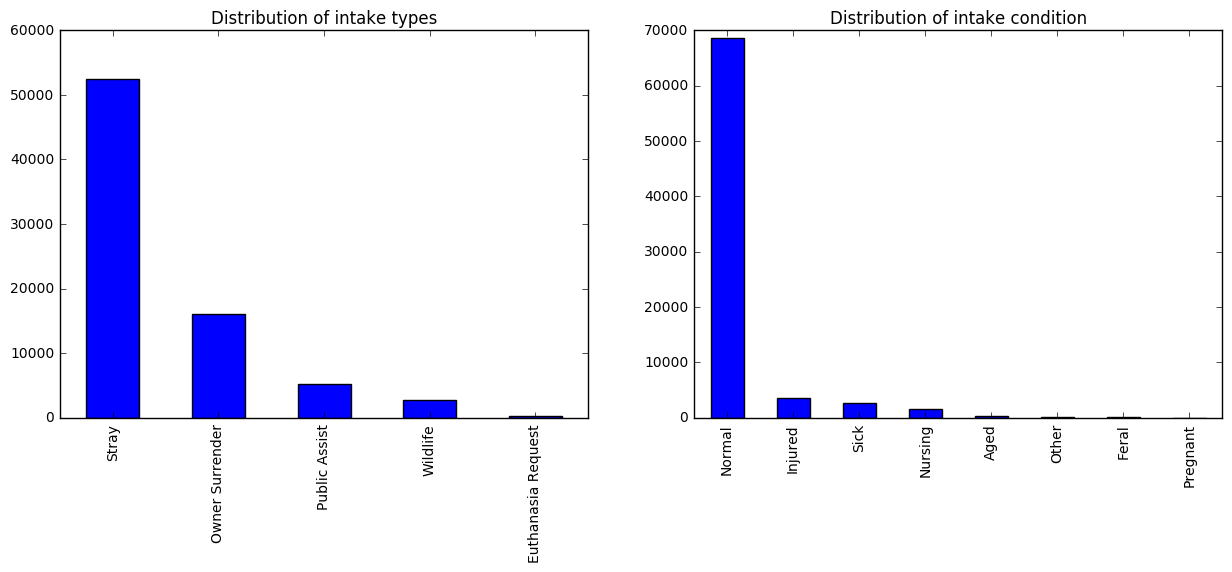

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2)
records['Intake_Type'].value_counts().plot(kind='bar', ax=axes[0], figsize=(15,5), title = "Distribution of intake types")
records['IntakeCondition'].value_counts().plot(kind='bar', ax=axes[1], figsize=(15,5), title = "Distribution of intake condition")

In [15]:
intake_gb = records.groupby(['Intake_Type','Outcome_Type'])['Outcome_Type'].count().unstack()
intake_gb = intake_gb.T

def get_perc(val,col):
    return val / intake_gb[col].sum() * 100

intake_gb_perc = pd.DataFrame()
for col in intake_gb.columns:
    intake_gb_perc[col] = intake_gb[col].apply(get_perc, args=(col,))

intake_gb_perc

,Euthanasia Request,Owner Surrender,Public Assist,Stray,Wildlife
Outcome_Type,,,,,
Adoption,8.148148,62.854308,14.323358,40.934547,0.072254
Died,1.111111,0.440365,0.357613,0.718150,2.998555
Disposal,NaN,0.012405,0.451722,0.049528,7.406069
Euthanasia,71.481481,3.677976,5.383023,3.745047,87.861272
Missing,NaN,0.043416,0.075287,0.074291,0.036127
Relocate,NaN,NaN,NaN,0.005715,0.361272
Return to Owner,6.296296,8.242883,66.610201,23.828482,0.072254
Rto-Adopt,NaN,0.031012,NaN,0.034288,NaN
Transfer,12.962963,24.697637,12.798795,30.609951,1.192197


In [16]:
# What are the top two outcomes by intake type?
def find_top_two_outcomes(col):
    col = col.sort_values(ascending=False)
    print col[:2]

for col in intake_gb_perc.columns:
    find_top_two_outcomes(intake_gb_perc[col])

Outcome_Type
Euthanasia    71.481481
Transfer      12.962963
Name: Euthanasia Request, dtype: float64
Outcome_Type
Adoption    62.854308
Transfer    24.697637
Name: Owner Surrender, dtype: float64
Outcome_Type
Return to Owner    66.610201
Adoption           14.323358
Name: Public Assist, dtype: float64
Outcome_Type
Adoption    40.934547
Transfer    30.609951
Name: Stray, dtype: float64
Outcome_Type
Euthanasia    87.861272
Disposal       7.406069
Name: Wildlife, dtype: float64


## How long does the average animal spend in the shelter? Does that differ based on animal type/gender/age? Which types of animals are adopted the quickest?

Median 4 days 22:11:00 -- true average stay
Mean 15 days 02:57:04.824817 -- mean is skewed by animals with long stays
Mode 0   00:14:00
dtype: timedelta64[ns] -- most likely transfered


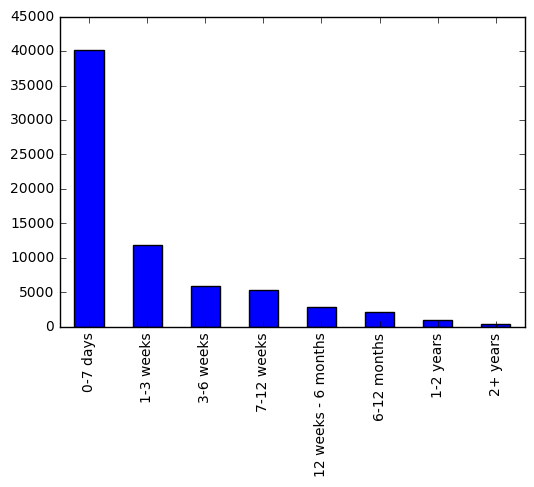

In [17]:
print "Median", records["DateTime_length"].median(), "-- true average stay"
print "Mean", records["DateTime_length"].mean(), "-- mean is skewed by animals with long stays"
print "Mode", records["DateTime_length"].mode(), "-- most likely transfered"
records['Days_length'].value_counts().plot(kind="bar")

### What kinds of animals are in the shelter? How does that affect length of stay?

In [18]:
records['Animal_Type_intake'].value_counts()

Dog          48097
Cat          25125
Other         3493
Bird           254
Livestock        8
Name: Animal_Type_intake, dtype: int64

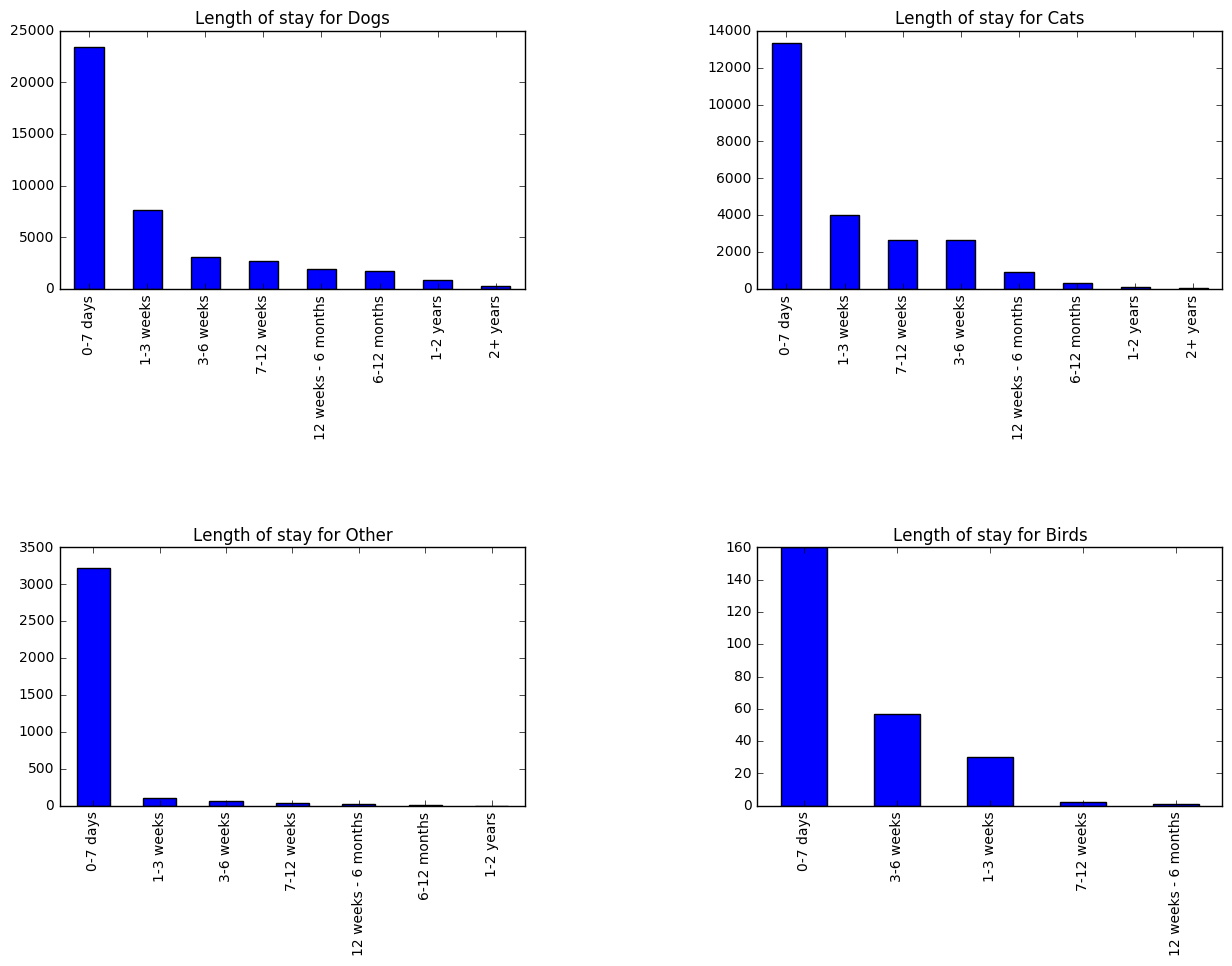

In [19]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.subplots_adjust(hspace=1, wspace = .5)

records[records["Animal_Type_intake"] == "Dog"]['Days_length'].value_counts().plot(kind='bar',ax=axes[0,0], figsize=(15,10), title = "Length of stay for Dogs")
records[records["Animal_Type_intake"] == "Cat"]['Days_length'].value_counts().plot(kind='bar',ax=axes[0,1], figsize=(15,10), title = "Length of stay for Cats")
records[records["Animal_Type_intake"] == "Other"]['Days_length'].value_counts().plot(kind='bar',ax=axes[1,0], figsize=(15,10), title = "Length of stay for Other")
records[records["Animal_Type_intake"] == "Bird"]['Days_length'].value_counts().plot(kind='bar',ax=axes[1,1], figsize=(15,10), title = "Length of stay for Birds")

### Is there a significant difference between length of stay for Dogs and Cats?
Average length of stay is slightly longer for cats.

In [20]:
from scipy.stats import ttest_ind

dog_records = records[records["Animal_Type_intake"] == "Dog"]
cat_records = records[records["Animal_Type_intake"] == "Cat"]

print "Dog Mean: ", dog_records["DateTime_length"].mean()
print "Dog Median: ", dog_records["DateTime_length"].median()
print "Cat Mean: ", cat_records["DateTime_length"].mean()
print "Cat Median: ", cat_records["DateTime_length"].median()
print ttest_ind(dog_records["DateTime_length"].astype('timedelta64[D]'), cat_records["DateTime_length"].astype('timedelta64[D]'))

Dog Mean:  14 days 01:51:08.355614
Dog Median:  5 days 01:14:00
Cat Mean:  18 days 18:45:55.140298
Cat Median:  5 days 05:26:00
Ttest_indResult(statistic=-4.4799766056687478, pvalue=7.4764007669523722e-06)


### Given an animal is adopted, is there a significant difference between length of stay for Dogs and Cats?
Average length of stay for adoptions is significantly longer for cats.

In [21]:
dog_adopted_records = dog_records[dog_records["Outcome_Type"] == "Adoption"]
cat_adopted_records = cat_records[cat_records["Outcome_Type"] == "Adoption"]

print "Dog Adopted Mean: ", dog_adopted_records["DateTime_length"].mean()
print "Dog Adopted Median: ", dog_adopted_records["DateTime_length"].median()
print "Cat Adopted Mean: ", cat_adopted_records["DateTime_length"].mean()
print "Cat Adopted Median: ", cat_adopted_records["DateTime_length"].median()
print ttest_ind(dog_adopted_records["DateTime_length"].astype('timedelta64[D]'), cat_adopted_records["DateTime_length"].astype('timedelta64[D]'))

Dog Adopted Mean:  21 days 12:08:31.021870
Dog Adopted Median:  7 days 01:15:00
Cat Adopted Mean:  32 days 03:13:04.975691
Cat Adopted Median:  22 days 12:13:30
Ttest_indResult(statistic=-7.0348944575730084, pvalue=2.0339295058256773e-12)


### Given an animal is adopted, is there a significant difference between length of stay for Female vs Male dogs and cats?
Not a significant difference between Dogs, almost a significant difference between cats. Male animals are adopted faster across the board.

In [22]:
male_dog_adopted_records = dog_adopted_records[dog_adopted_records["Gender"] == "Male"]
female_dog_adopted_records = dog_adopted_records[dog_adopted_records["Gender"] == "Female"]
male_cat_adopted_records = cat_adopted_records[cat_adopted_records["Gender"] == "Male"]
female_cat_adopted_records = cat_adopted_records[cat_adopted_records["Gender"] == "Female"]

print "Male Dog Adopted Mean: ", male_dog_adopted_records["DateTime_length"].mean()
print "Female Dog Adopted Mean: ", female_dog_adopted_records["DateTime_length"].mean()
print "Male Cat Adopted Mean: ", male_cat_adopted_records["DateTime_length"].mean()
print "Female Cat Adopted Mean: ", female_cat_adopted_records["DateTime_length"].mean()

print "Male vs Female Dog", ttest_ind(male_dog_adopted_records["DateTime_length"].astype('timedelta64[D]'), female_dog_adopted_records["DateTime_length"].astype('timedelta64[D]'))
print "Male vs Female Cat", ttest_ind(male_cat_adopted_records["DateTime_length"].astype('timedelta64[D]'), female_cat_adopted_records["DateTime_length"].astype('timedelta64[D]'))

Male Dog Adopted Mean:  20 days 18:29:46.794232
Female Dog Adopted Mean:  22 days 06:44:19.474338
Male Cat Adopted Mean:  30 days 09:33:18.362865
Female Cat Adopted Mean:  33 days 18:39:58.953298
Male vs Female Dog Ttest_indResult(statistic=-0.80597657113653964, pvalue=0.42026527739021102)
Male vs Female Cat Ttest_indResult(statistic=-1.6635290900407023, pvalue=0.096235876580116703)


### Given an animal is adopted, is there a significant difference between length of stay based on Age for dogs and cats?

In [23]:
print "DOGS"
dog_adopted_records["DateTime_length_int"] = dog_adopted_records["DateTime_length"].astype('timedelta64[D]')
dog_adopted_records_gb_age = dog_adopted_records.groupby(["Age_Bucket"])["DateTime_length_int"].mean()
print dog_adopted_records_gb_age

print "\nCATS"
cat_adopted_records["DateTime_length_int"] = cat_adopted_records["DateTime_length"].astype('timedelta64[D]')
cat_adopted_records_gb_age = cat_adopted_records.groupby(["Age_Bucket"])["DateTime_length_int"].mean()
print cat_adopted_records_gb_age

DOGS
Age_Bucket
1-3 years           14.823166
1-6 months          22.161159
1-6 weeks           49.776699
4-6 years           28.748453
7+ years            47.360616
7-12 months         19.501130
Less than 1 week    70.900621
Name: DateTime_length_int, dtype: float64

CATS
Age_Bucket
1-3 years           13.756214
1-6 months          26.942706
1-6 weeks           67.023282
4-6 years           34.409346
7+ years            34.990637
7-12 months         -1.301136
Less than 1 week    86.952000
Name: DateTime_length_int, dtype: float64


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Are there certain months that people tend to make more adoptions on? What about certain days of the week (weekends)?
0 is Monday, 6 is Sunday

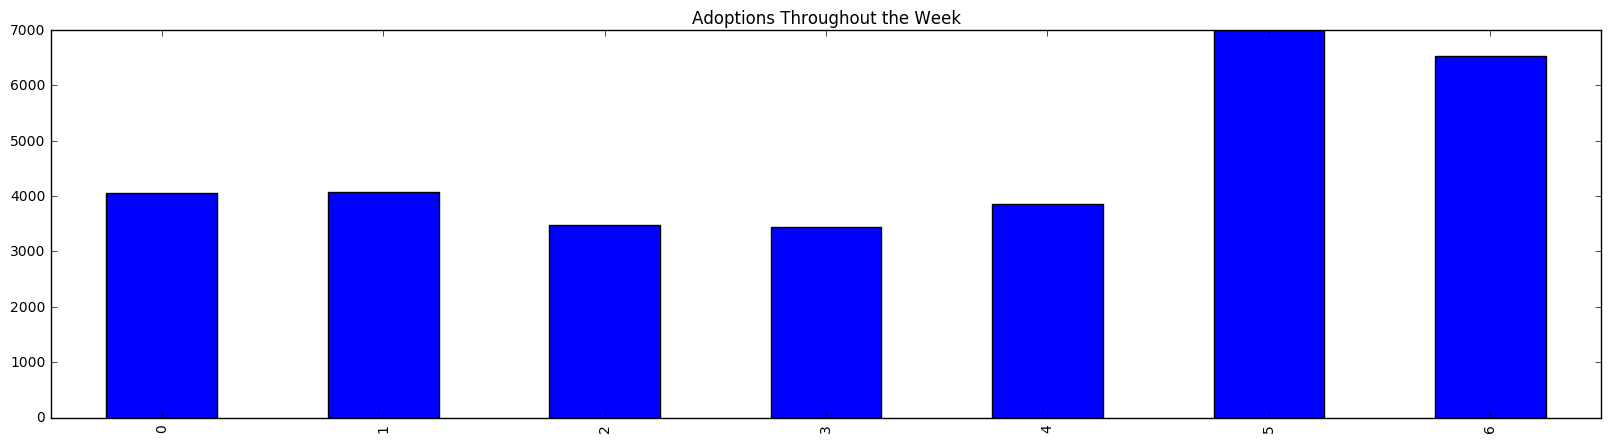

In [24]:
records[records['Outcome_Type'] == "Adoption"]['DateTime_outcome'].dt.dayofweek.value_counts().sort_index().plot(kind="bar", figsize=(20,5), title = "Adoptions Throughout the Week")

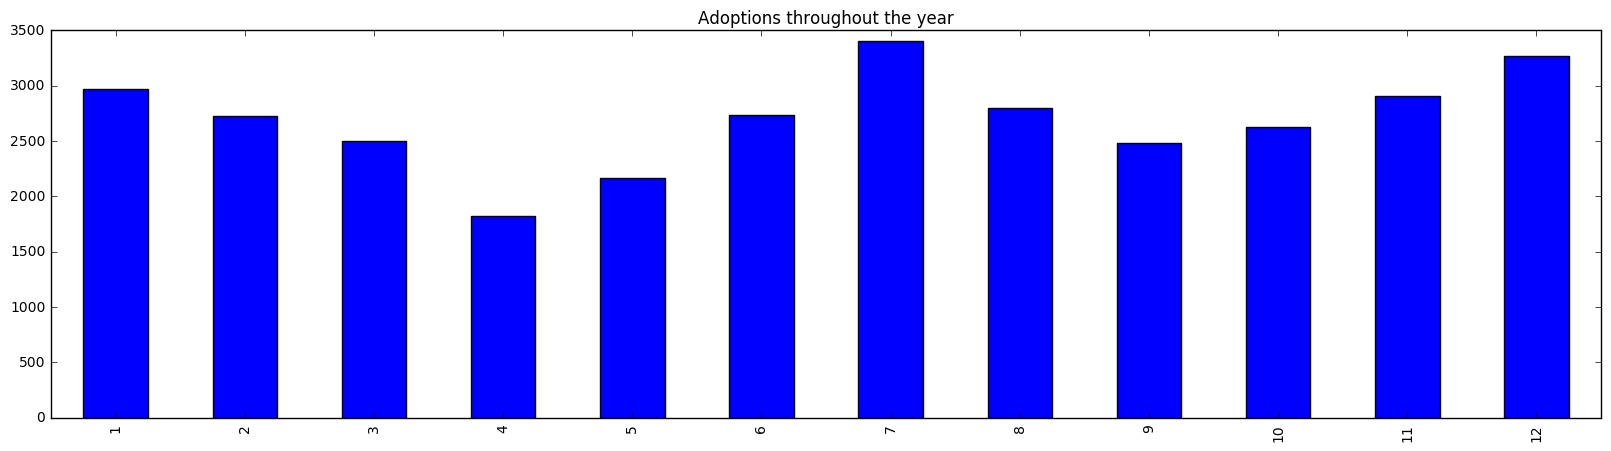

In [25]:
records[records['Outcome_Type'] == "Adoption"]['DateTime_outcome'].dt.month.value_counts().sort_index().plot(kind='bar', figsize=(20,5), title = "Adoptions throughout the year")

## How does likelihood of being adopted vs euthanized vs return to owner vs transfer change based on animal type, gender, and age?

### What is the likelihood of outcomes based on Dog vs Cat?

In [26]:
print "DOGS"
dog_records_outcome_gb = dog_records.groupby(['Outcome_Type'])['Outcome_Type'].count()
print float(dog_records_outcome_gb["Adoption"]) / float(dog_records_outcome_gb.sum()) * 100, "% adopted"
print float(dog_records_outcome_gb["Euthanasia"]) / float(dog_records_outcome_gb.sum()) * 100, "% euthanized"
print float(dog_records_outcome_gb["Return to Owner"]) / float(dog_records_outcome_gb.sum()) * 100, "% return to owner"
print float(dog_records_outcome_gb["Transfer"]) / float(dog_records_outcome_gb.sum()) * 100, "% transferred"

print "\nCATS"
cat_records_outcome_gb = cat_records.groupby(['Outcome_Type'])['Outcome_Type'].count()
print float(cat_records_outcome_gb["Adoption"]) / float(cat_records_outcome_gb.sum()) * 100, "% adopted"
print float(cat_records_outcome_gb["Euthanasia"]) / float(cat_records_outcome_gb.sum()) * 100, "% euthanized"
print float(cat_records_outcome_gb["Return to Owner"]) / float(cat_records_outcome_gb.sum()) * 100, "% return to owner"
print float(cat_records_outcome_gb["Transfer"]) / float(cat_records_outcome_gb.sum()) * 100, "% transferred"

DOGS
44.6814703925 % adopted
3.33291749834 % euthanized
33.3083832335 % return to owner
18.3092149035 % transferred

CATS
42.5728387199 % adopted
4.98328291673 % euthanized
5.32956535584 % return to owner
45.6774398981 % transferred


### What is the likelihood of outcomes based on gender?

In [27]:
print "MALE DOGS"
male_dog_records_outcome_gb = dog_records[dog_records['Gender'] == "Male"].groupby(['Outcome_Type'])['Outcome_Type'].count()
print float(male_dog_records_outcome_gb["Adoption"]) / float(male_dog_records_outcome_gb.sum()) * 100, "% adopted"
print float(male_dog_records_outcome_gb["Euthanasia"]) / float(male_dog_records_outcome_gb.sum()) * 100, "% euthanized"
print float(male_dog_records_outcome_gb["Return to Owner"]) / float(male_dog_records_outcome_gb.sum()) * 100, "% return to owner"
print float(male_dog_records_outcome_gb["Transfer"]) / float(male_dog_records_outcome_gb.sum()) * 100, "% transferred"

print "\nFEMALE DOGS"
female_dog_records_outcome_gb = dog_records[dog_records['Gender'] == "Female"].groupby(['Outcome_Type'])['Outcome_Type'].count()
print float(female_dog_records_outcome_gb["Adoption"]) / float(female_dog_records_outcome_gb.sum()) * 100, "% adopted"
print float(female_dog_records_outcome_gb["Euthanasia"]) / float(female_dog_records_outcome_gb.sum()) * 100, "% euthanized"
print float(female_dog_records_outcome_gb["Return to Owner"]) / float(female_dog_records_outcome_gb.sum()) * 100, "% return to owner"
print float(female_dog_records_outcome_gb["Transfer"]) / float(female_dog_records_outcome_gb.sum()) * 100, "% transferred"

print "\nMALE CATS"
male_cat_records_outcome_gb = cat_records[cat_records['Gender'] == "Male"].groupby(['Outcome_Type'])['Outcome_Type'].count()
print float(male_cat_records_outcome_gb["Adoption"]) / float(male_cat_records_outcome_gb.sum()) * 100, "% adopted"
print float(male_cat_records_outcome_gb["Euthanasia"]) / float(male_cat_records_outcome_gb.sum()) * 100, "% euthanized"
print float(male_cat_records_outcome_gb["Return to Owner"]) / float(male_cat_records_outcome_gb.sum()) * 100, "% return to owner"
print float(male_cat_records_outcome_gb["Transfer"]) / float(male_cat_records_outcome_gb.sum()) * 100, "% transferred"

print "\nFEMALE CATS"
female_cat_records_outcome_gb = cat_records[cat_records['Gender'] == "Female"].groupby(['Outcome_Type'])['Outcome_Type'].count()
print float(female_cat_records_outcome_gb["Adoption"]) / float(female_cat_records_outcome_gb.sum()) * 100, "% adopted"
print float(female_cat_records_outcome_gb["Euthanasia"]) / float(female_cat_records_outcome_gb.sum()) * 100, "% euthanized"
print float(female_cat_records_outcome_gb["Return to Owner"]) / float(female_cat_records_outcome_gb.sum()) * 100, "% return to owner"
print float(female_cat_records_outcome_gb["Transfer"]) / float(female_cat_records_outcome_gb.sum()) * 100, "% transferred"

MALE DOGS
42.2555180871 % adopted
3.59058859595 % euthanized
36.0783261803 % return to owner
17.7306866953 % transferred

FEMALE DOGS
47.9316505566 % adopted
2.95478491914 % euthanized
30.2029410417 % return to owner
18.5807870264 % transferred

MALE CATS
46.0487804878 % adopted
5.34811529933 % euthanized
6.74057649667 % return to owner
40.3902439024 % transferred

FEMALE CATS
47.5133828354 % adopted
4.07528924193 % euthanized
4.89552754274 % return to owner
42.2897599724 % transferred


### What is the likelihood of outcome based on age?

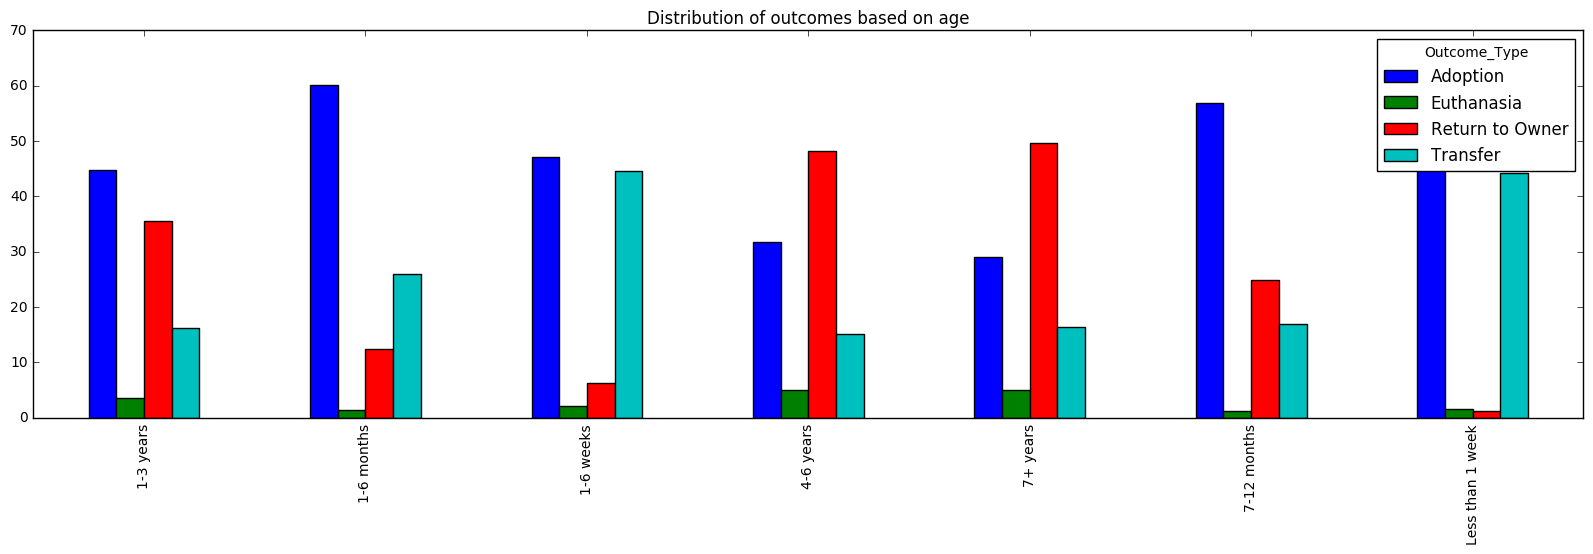

In [28]:
dog_records_outcome_age_gb = dog_records.groupby(['Outcome_Type','Age_Bucket'])['Age_Bucket'].count().unstack()
# Drop outcomes we're not interested in
dog_records_outcome_age_gb = dog_records_outcome_age_gb.drop(dog_records_outcome_age_gb.index[[1,2,4,6]])

# Transform into a percentage
def get_perc_outcome(val,col):
    return float(val) / float(dog_records_outcome_age_gb[col].sum()) * 100

perc_dog_records_outcome_age_gb = pd.DataFrame()
for col in dog_records_outcome_age_gb.columns:
    perc_dog_records_outcome_age_gb[col] = dog_records_outcome_age_gb[col].apply(get_perc_outcome, args=(col,))

perc_dog_records_outcome_age_gb = perc_dog_records_outcome_age_gb.T
perc_dog_records_outcome_age_gb.plot(kind="bar", figsize=(20,5), title = "Distribution of outcomes based on age")

In [29]:
records.columns = ['Animal ID','Name_intake','DateTime_intake','MonthYear_intake','Found_Location','Intake_Type',\
                   'IntakeCondition','Animal_Type_intake','Sex','Age','Breed_intake','Color_intake','Name_outcome',\
                   'DateTime_outcome','MonthYear_outcome','Outcome_Type','Outcome_Subtype','Sex_upon_Outcome',\
                   'Age_upon_Outcome','Gender','fixed_intake','fixed_outcome','fixed_changed','Age_Bucket',\
                   'retriever','shepherd','beagle','terrier','boxer','poodle','rottweiler','dachshund',\
                   'chihuahua','pit_bull','DateTime_length','Days_length']

## General Knowledge:

In [30]:
# What do the outcome subtypes mean? How do those match up to outcomes?
records.groupby(by=['Outcome_Type','Outcome_Subtype'])['Animal ID'].count()

Outcome_Type  Outcome_Subtype    
Adoption      Barn                       1
              Foster                  4786
              Offsite                  325
Died          At Vet                    28
              Enroute                   30
              In Foster                116
              In Kennel                280
              In Surgery                11
Euthanasia    Aggressive               620
              At Vet                     4
              Behavior                 144
              Court/Investigation       28
              Medical                  217
              Rabies Risk             2062
              Suffering               2208
              Underage                  26
Missing       In Foster                 15
              In Kennel                  7
              Possible Theft            16
Transfer      Barn                       2
              Partner                17367
              SCRP                    3430
Name: Animal ID, dty

In [31]:
records['Name_intake'] = records['Name_intake'].fillna('No Name')
records['Have_name_start'] = 0
records.ix[records['Name_intake'] != 'No Name','Have_name_start'] = 1
records['Name_outcome'] = records['Name_outcome'].fillna('No Name')
records['Have_name_end'] = 0
records.ix[records['Name_intake'] != 'No Name', 'Have_name_end'] = 1

# Can we predict adoption v other outcomes?

In [32]:
# Set the target column for prediction
records['Target'] = 0
adopt_mask = records['Outcome_Type'] == 'Adoption'
records.ix[adopt_mask, 'Target'] = 1
records

,Animal ID,Name_intake,DateTime_intake,MonthYear_intake,Found_Location,Intake_Type,IntakeCondition,Animal_Type_intake,Sex,Age,...,poodle,rottweiler,dachshund,chihuahua,pit_bull,DateTime_length,Days_length,Have_name_start,Have_name_end,Target
0,A730601,No Name,2016-07-07 12:11:00,07/07/2016 12:11:00 PM,1109 Shady Ln in Austin (TX),Stray,Normal,Cat,Intact Male,7 months,...,0,0,0,0,0,0 days 20:49:00,0-7 days,0,0,0
1,A683644,*Zoey,2014-07-13 11:02:00,07/13/2014 11:02:00 AM,Austin (TX),Owner Surrender,Nursing,Dog,Intact Female,4 weeks,...,0,0,0,0,0,115 days 23:04:00,12 weeks - 6 months,1,1,1
2,A676515,Rico,2014-04-11 08:45:00,04/11/2014 08:45:00 AM,615 E. Wonsley in Austin (TX),Stray,Normal,Dog,Intact Male,2 months,...,0,0,0,0,1,3 days 09:53:00,0-7 days,1,1,0
3,A742953,No Name,2017-01-31 13:30:00,01/31/2017 01:30:00 PM,S Hwy 183 And Thompson Lane in Austin (TX),Stray,Normal,Dog,Intact Male,2 years,...,0,0,0,0,0,4 days 00:47:00,0-7 days,0,0,0
4,A679549,*Gilbert,2014-05-22 15:43:00,05/22/2014 03:43:00 PM,124 W Anderson in Austin (TX),Stray,Normal,Cat,Intact Male,1 month,...,0,0,0,0,0,24 days 22:11:00,3-6 weeks,1,1,0
5,A683798,Mustachala,2016-07-21 12:16:00,07/21/2016 12:16:00 PM,3118 Windsor Rd in Austin (TX),Stray,Normal,Cat,Spayed Female,3 years,...,0,0,0,0,0,88 days 22:39:00,12 weeks - 6 months,1,1,1
6,A683798,Mustachala,2016-07-21 12:16:00,07/21/2016 12:16:00 PM,3118 Windsor Rd in Austin (TX),Stray,Normal,Cat,Spayed Female,3 years,...,0,0,0,0,0,-729 days +05:50:00,NaN,1,1,1
7,A683798,Mustachala,2014-07-15 15:38:00,07/15/2014 03:38:00 PM,Austin (TX),Owner Surrender,Normal,Cat,Intact Female,1 year,...,0,0,0,0,0,825 days 19:17:00,2+ years,1,1,1
8,A683798,Mustachala,2014-07-15 15:38:00,07/15/2014 03:38:00 PM,Austin (TX),Owner Surrender,Normal,Cat,Intact Female,1 year,...,0,0,0,0,0,8 days 02:28:00,1-3 weeks,1,1,1
9,A683656,No Name,2014-07-13 13:20:00,07/13/2014 01:20:00 PM,8238 Research Blvd in Austin (TX),Stray,Normal,Cat,Intact Male,2 months,...,0,0,0,0,0,4 days 03:37:00,0-7 days,0,0,1


In [33]:
# What's our baseline prediction accuracy?
majority = float(records['Target'].value_counts()[0])
total = records['Target'].value_counts().sum()
baseline = majority / total
print format(baseline, '.4f') + '%'
records['Target'].value_counts()

0.5790%


0    44569
1    32408
Name: Target, dtype: int64

# Let's try K-Nearest neighbors.

In [34]:
y, X = dmatrices('Target ~ Gender + Age_Bucket + Animal_Type_intake + Intake_Type + IntakeCondition + retriever + shepherd + beagle + terrier + boxer + poodle + rottweiler + dachshund + chihuahua + pit_bull + Have_name_start + Have_name_end', data=records, return_type='dataframe')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [48]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=3)
model.fit(X, y)
prediction_on_training = model.predict(X_train)
print 'Train accuracy:', metrics.accuracy_score(y_train, prediction_on_training)
prediction_on_test = model.predict(X_test)
print 'Test accuracy:', metrics.accuracy_score(y_test, prediction_on_test)
dot_data = StringIO()
export_graphviz(model, out_file=dot_data, feature_names=X.columns.values)
pydot_ng.graph_from_dot_data(dot_data.getvalue()).write_png('Tree Model')

Train accuracy: 0.651767484687
Test accuracy: 0.653635981505


True

In [41]:
neighbor_list = [50,250,500]

for neighbor_num in neighbor_list:
    model = neighbors.KNeighborsClassifier(n_neighbors=neighbor_num,
                                       weights='uniform',
                                       p=2)
    
    print 'Number of Neighbors:', neighbor_num
    model.fit(X_train, y_train)
    prediction_on_training = model.predict(X_train)
    print 'Train accuracy:', metrics.accuracy_score(y_train, prediction_on_training)
    prediction_on_test = model.predict(X_test)
    print 'Test accuracy:', metrics.accuracy_score(y_test, prediction_on_test)
    print ''

Number of Neighbors: 50


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Train accuracy: 0.680471596141
Test accuracy: 0.678062678063

Number of Neighbors: 250


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Train accuracy: 0.677148804996
Test accuracy: 0.676474709262

Number of Neighbors: 500


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Train accuracy: 0.675507426238
Test accuracy: 0.675353790108



# We'll give Naive Bayes a shot.

In [42]:
model = naive_bayes.MultinomialNB()
model.fit(X, y)
prediction_on_training = model.predict(X_train)
print 'Train accuracy:', metrics.accuracy_score(y_train, prediction_on_training)
prediction_on_test = model.predict(X_test)
print 'Test accuracy:', metrics.accuracy_score(y_test, prediction_on_test)

Train accuracy: 0.653388846631
Test accuracy: 0.658680117697


//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Maybe an ensemble method - random forest?

In [45]:
model_rf = RandomForestClassifier(n_estimators=100, max_depth=3)
model_rf.fit(X, y)
prediction_on_training = model_rf.predict(X_train)
print 'Train accuracy:', metrics.accuracy_score(y_train, prediction_on_training)
prediction_on_test = model.predict(X_test)
print 'Test accuracy:', metrics.accuracy_score(y_test, prediction_on_test)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


Train accuracy: 0.653548981144
Test accuracy: 0.691793937696
